In [1]:
import sys
!{sys.executable} -m pip install numpy matplotlib pandas PyWavelets statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram, stft
from scipy.fftpack import fft
import statsmodels.api as sm
import pywt

In [4]:
data = pd.read_csv("HR_midterm.csv")
hr = data['HR']
data.head()

,HR
0,84.00
1,85.00
2,86.00
3,86.75
4,87.40


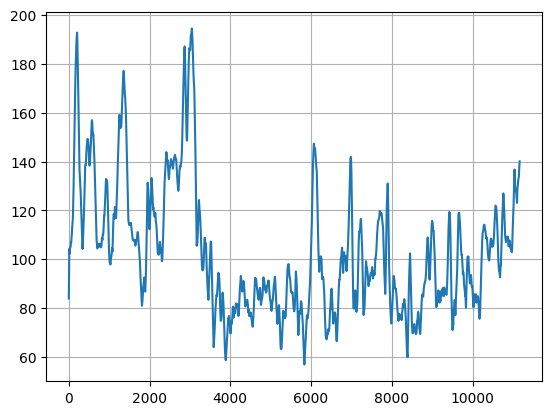

In [23]:
plt.plot([i for i in range(0, len(hr))], hr, linestyle='-')
plt.grid(True)

In [24]:
mean = hr.mean()
print('Mean:', mean)

Mean: 103.11374697824334


In [29]:
variance = hr.var(ddof=0)
noise_variance = (hr + 5 * np.random.randn(len(hr))).var()
print('Variance:', variance)
print('Noise variance:', noise_variance)

Variance: 691.8790066692595
Noise variance: 718.55995120988


In [30]:
max_hr = hr.max()
min_hr = hr.min()
amplitude = max_hr - min_hr

print(f'Max hr: {max_hr}\nMin hr: {min_hr}\nAmplitude: {amplitude}')

Max hr: 194.47
Min hr: 57.0
Amplitude: 137.47


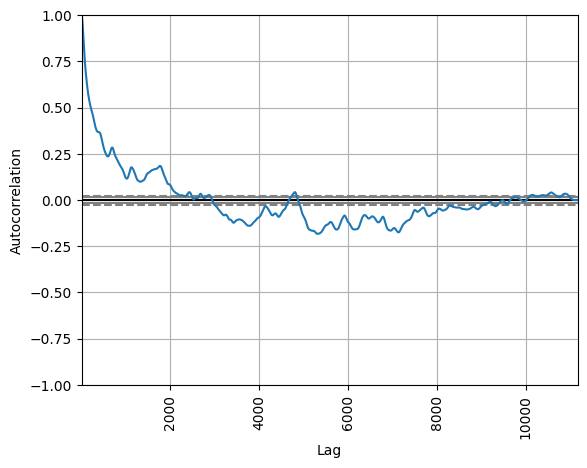

In [7]:
pd.plotting.autocorrelation_plot(hr).plot()
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_101109/525254096.py:7: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(time_segments, frequencies, np.log(stft_data))


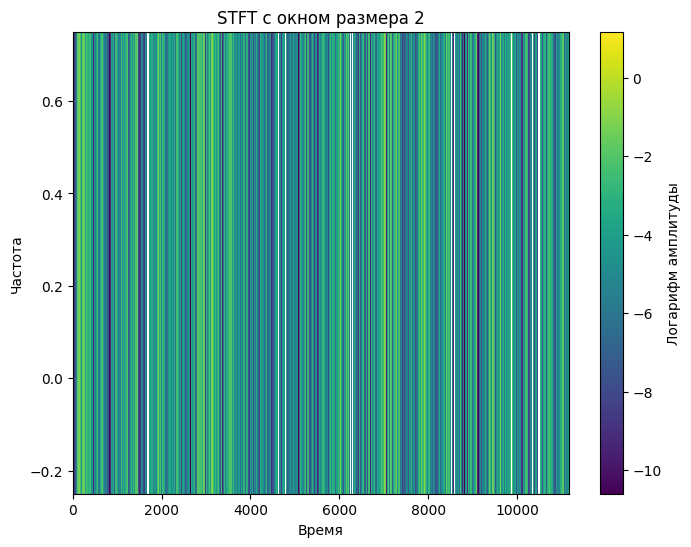

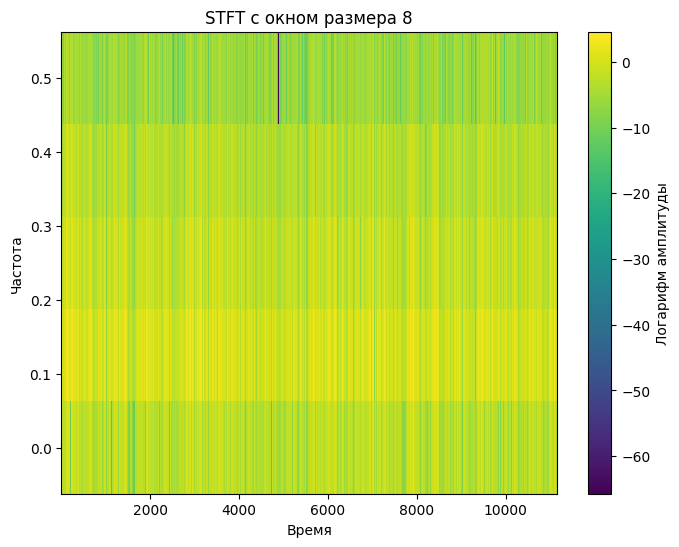

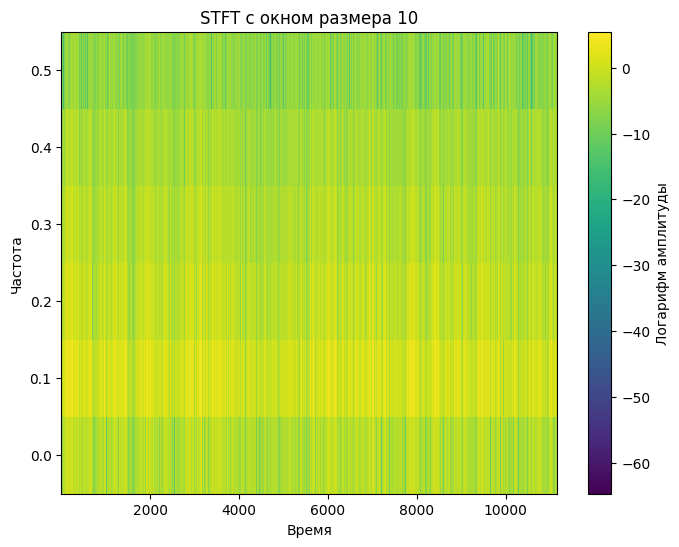

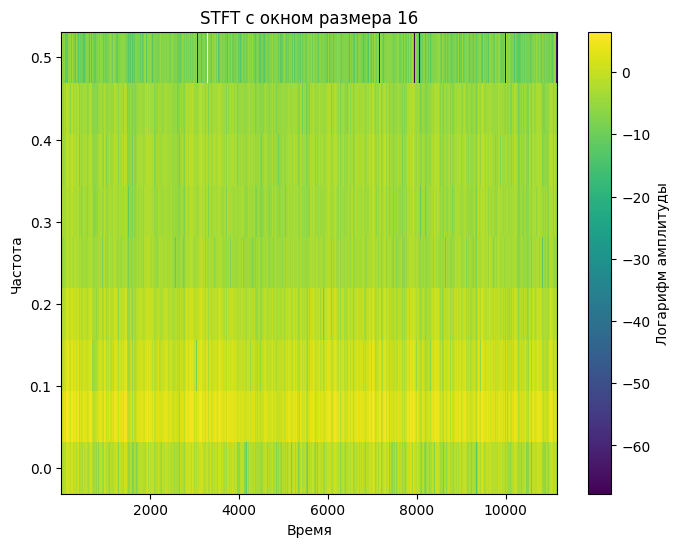

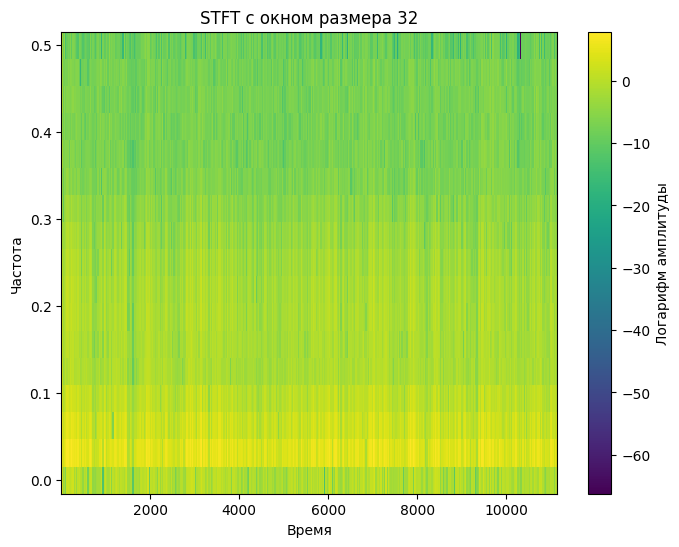

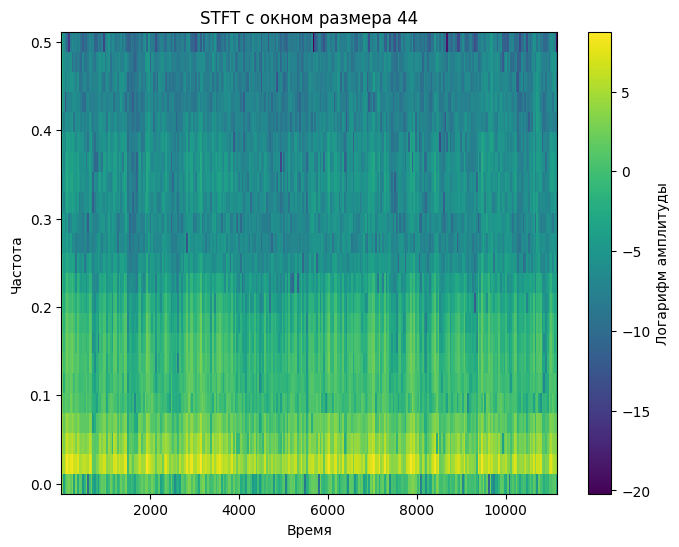

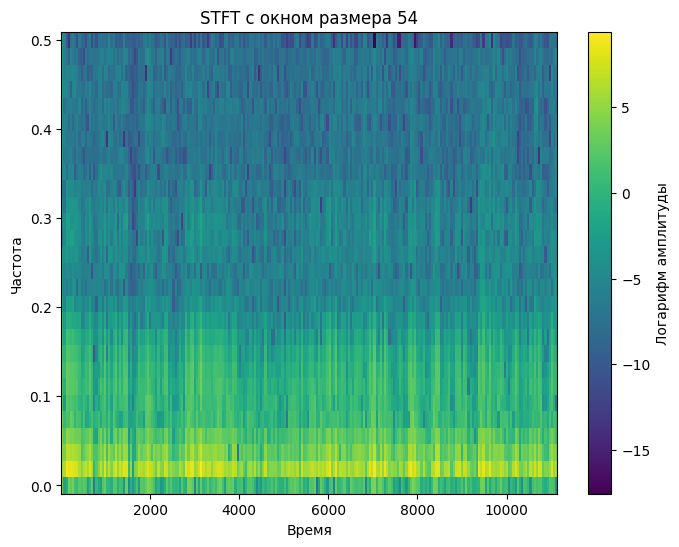

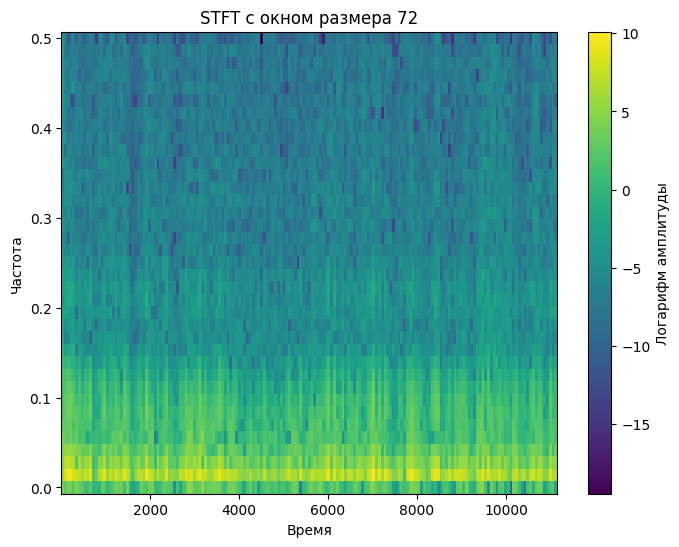

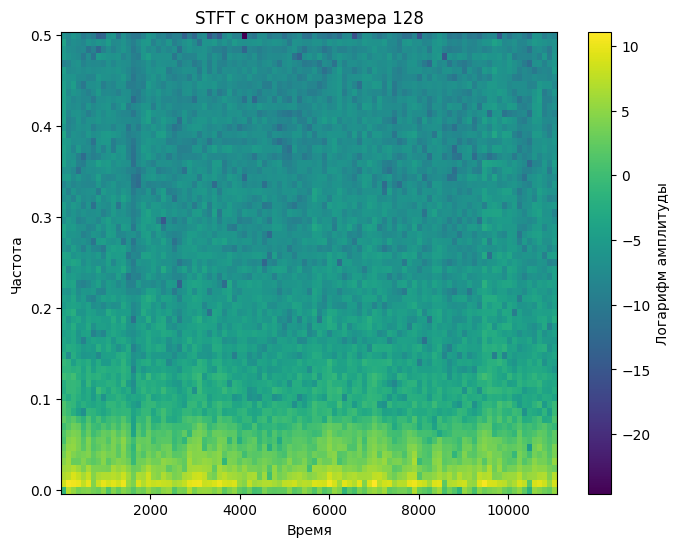

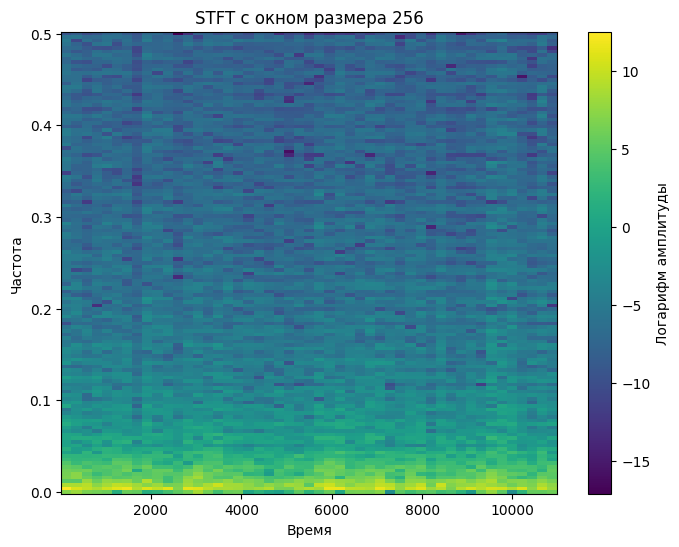

In [7]:
data = hr.dropna().values
window_sizes = [2, 8, 10, 16, 32, 44, 54, 72, 128, 256]

for sz in window_sizes:
    frequencies, time_segments, stft_data = spectrogram(data, fs=1.0, nperseg=sz)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(time_segments, frequencies, np.log(stft_data))
    plt.title(f'STFT с окном размера {sz}')
    plt.xlabel('Время')
    plt.ylabel('Частота')
    plt.colorbar().set_label('Логарифм амплитуды')
    plt.show()

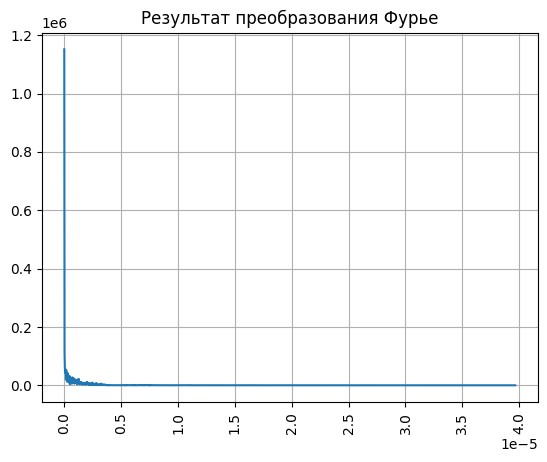

In [18]:
data = hr.dropna().values
X = fft(data)
N = len(X)
n = np.arange(N)
# get the sampling rate
sr = 1 / (60 * 60)
T = N / sr
freq = n / T

# Get the one-sided specturm
n_oneside = N // 7
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.plot(f_oneside, np.abs(X[:n_oneside]))
plt.title('Результат преобразования Фурье')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

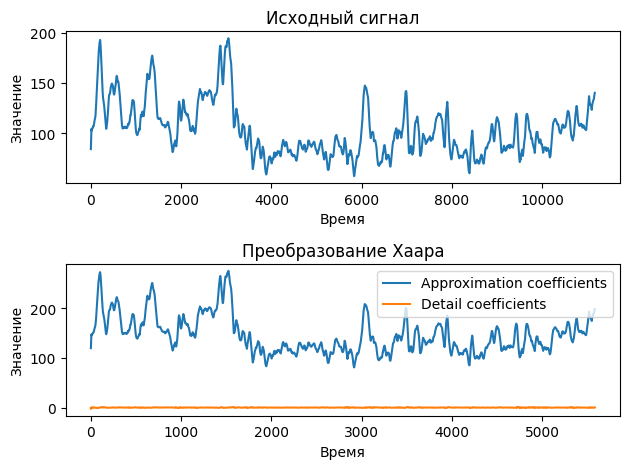

In [19]:
data = hr.dropna().values
c_a = pywt.dwt(data, "haar")

plt.subplot(2, 1, 1)
plt.plot(data)
plt.title('Исходный сигнал')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.subplot(2, 1, 2)
plt.plot(c_a[0], label='Approximation coefficients')  # Аппроксимационные коэффициенты
plt.plot(c_a[1], label='Detail coefficients')  # Детальные коэффициенты
plt.legend()
plt.title('Преобразование Хаара')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()

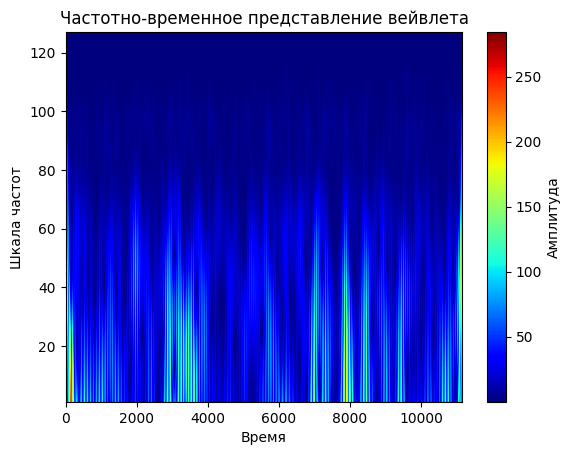

In [21]:
scales = np.arange(1, 128)  # Выбор шкалы частот

data = hr.dropna().values
# Выполнение непрерывного вейвлет-преобразования
cwtmatr, freqs = pywt.cwt(data, scales,
                          'morl')  # Выбор вейвлета, например, 'morl'

# Построение частотно-временного представления вейвлета
plt.imshow(np.abs(cwtmatr),
           extent=[0,
               len(hr.index),
               min(scales),
               max(scales)
           ],
           aspect='auto',
           cmap='jet')
plt.colorbar(label='Амплитуда')
plt.title('Частотно-временное представление вейвлета')
plt.xlabel('Время')
plt.ylabel('Шкала частот')
plt.show()

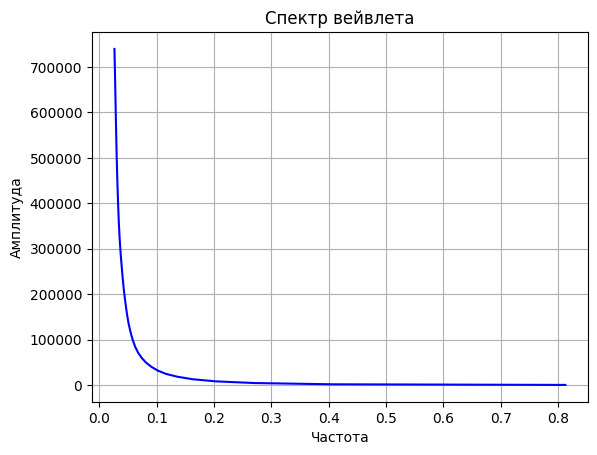

In [24]:
scales = np.arange(1, 32)  # Выбор шкалы частот

# Выполнение непрерывного вейвлет-преобразования Морле на основе временного ряда 'total'
cwtmatr, freqs = pywt.cwt(data, scales, 'morl')  # Выбор вейвлета, например, 'morl'

# Нахождение спектра вейвлета
wavelet_spectrum = np.sum(np.abs(cwtmatr) ** 2, axis=1)  # Расчет спектра вейвлета

# Построение графика спектра вейвлета
plt.plot(freqs, wavelet_spectrum, color='blue')
plt.title('Спектр вейвлета')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()


/home/vboxuser/projects/oirs/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


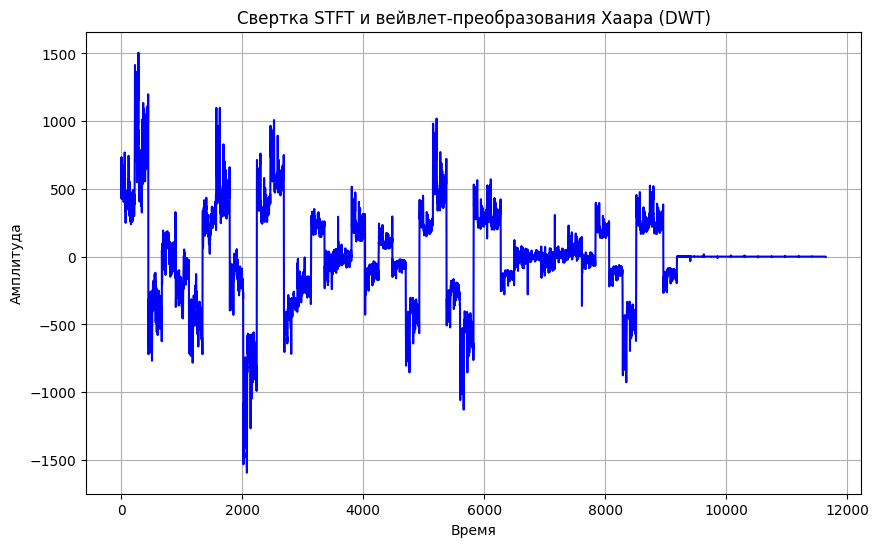

In [25]:
frequencies, time_segments, stft_data = stft(
    data, fs=0.5, nperseg=50)  # Параметры могут варьироваться

# Выполнение дискретного вейвлет-преобразования Хаара (DWT)
wavelet = 'haar'
wavelet_coeffs = pywt.dwt(stft_data.flatten(), wavelet)

# Свертка между результатами STFT и вейвлет-преобразования Хаара (DWT)
convolution_result = np.convolve(stft_data.flatten(),
                                 wavelet_coeffs[0],
                                 mode='same')

# Построение графика свертки
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(convolution_result)), convolution_result, color='blue')
plt.title('Свертка STFT и вейвлет-преобразования Хаара (DWT)')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()

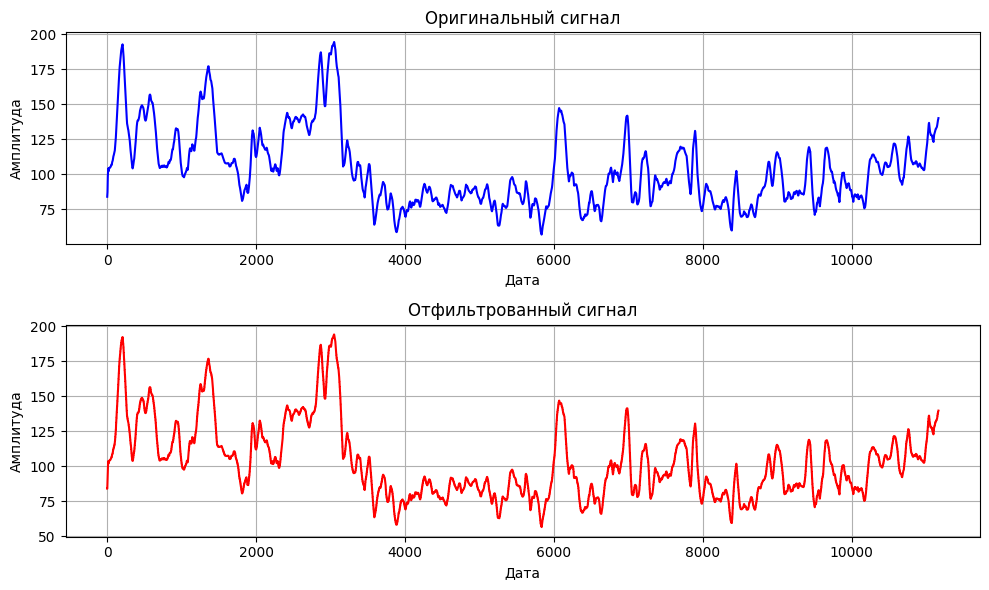

In [30]:
data = hr.dropna().values
wavelet = 'haar'
wavelet_coeffs = pywt.dwt(data, wavelet)

# Определение порога
threshold = np.std(
    wavelet_coeffs[-1])*2 

# Применение пороговой фильтрации к коэффициентам вейвлет-преобразования
thresholded_coeffs = pywt.threshold(wavelet_coeffs[0], threshold, mode='soft')

# Обратное вейвлет-преобразование для восстановления сигнала
filtered_signal = pywt.idwt(thresholded_coeffs, None, wavelet)

# Создание DataFrame с данными
index_length = len(hr.index)
filtered_signal = filtered_signal[:
                                            index_length]  # Приведение длины reconstructed_signal к длине grouped_data.index
new_df = pd.DataFrame({
    'hr': hr.index,
    'Dataset': filtered_signal
})
new_df = new_df.set_index('hr')
# Построение графиков оригинального и отфильтрованного сигналов
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(hr.index, hr, color='blue')
plt.title('Оригинальный сигнал')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(new_df.index, new_df['Dataset'], color='red')
plt.title('Отфильтрованный сигнал')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

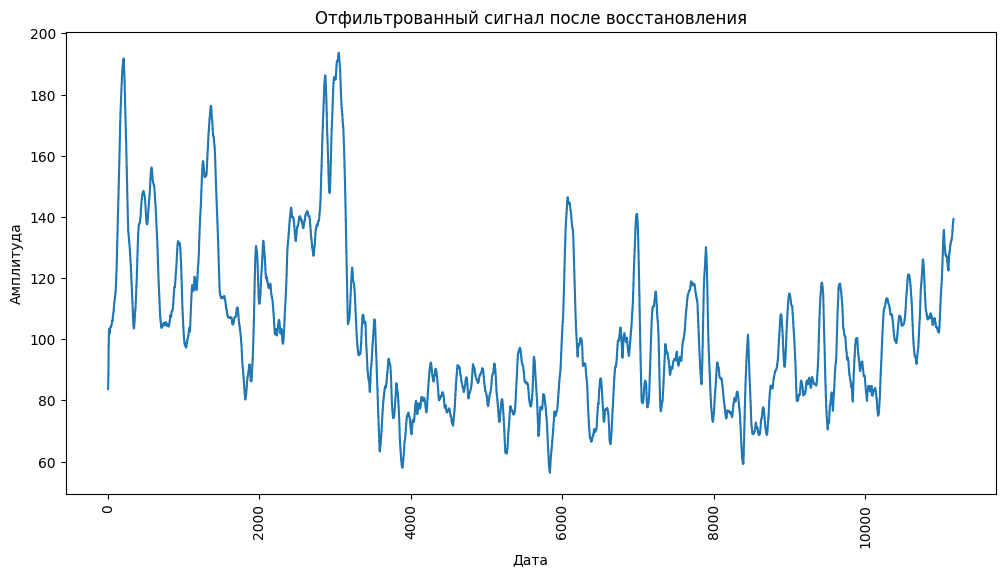

In [31]:
# Определение порога
threshold = np.std(wavelet_coeffs[-1]) * 4  # Пример порога (стандартное отклонение * 2)

# Применение пороговой фильтрации к коэффициентам вейвлет-преобразования
thresholded_coeffs = pywt.threshold(wavelet_coeffs[0], threshold, mode='soft')

# Обратное вейвлет-преобразование для восстановления сигнала
filtered_signal = pywt.idwt(thresholded_coeffs, None, wavelet)

# Выравниваем длины индекса и значений сигнала
if len(hr.index) != len(filtered_signal):
    grouped_data_index = hr.index[:len(filtered_signal)]
    filtered_signal = filtered_signal[:len(hr.index)]
else:
    grouped_data_index = hr.index

# Создаем DataFrame с колонкой 'total' из значений сигнала и 'dots' в качестве индекса
r_df = pd.DataFrame({'total': filtered_signal}, index= grouped_data_index)

# Строим график
plt.figure(figsize=(12,6), dpi=100)
plt.plot(grouped_data_index, filtered_signal)
plt.title('Отфильтрованный сигнал после восстановления')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.xticks(rotation=90)
plt.show()

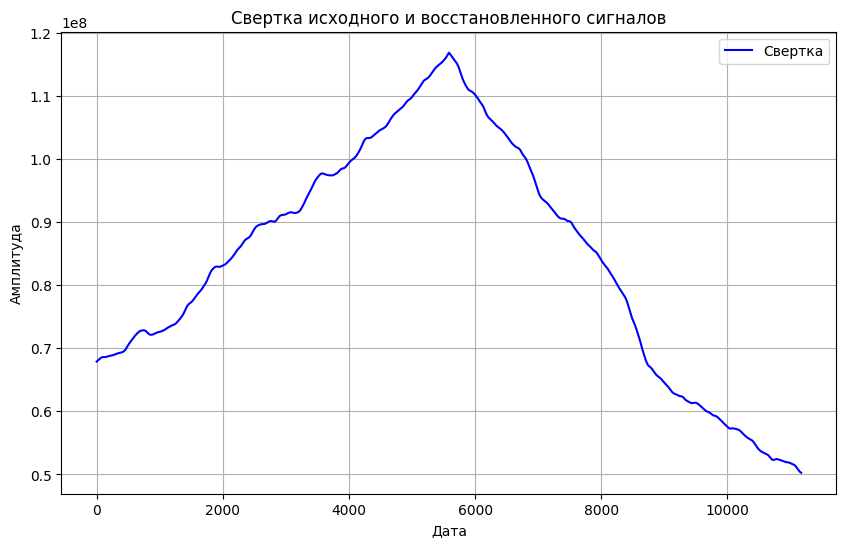

In [32]:
# Построение графика отфильтрованного сигнала
plt.figure(figsize=(10, 6))
    
# Свертка исходного и восстановленного сигналов
convolution_result = np.convolve(data, filtered_signal, mode='same')

if len(hr.index) != len(convolution_result):
    grouped_data_index = hr.index[:len(convolution_result)]
    filtered_signal = convolution_result[:len(hr.index)]
else:
    grouped_data_index = hr.index
    
plt.plot(grouped_data_index,convolution_result, color='blue', label='Свертка')

plt.title('Свертка исходного и восстановленного сигналов')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Вычисление коэффициента корреляции Пирсона
correlation_coefficient, _ = pearsonr(data, filtered_signal)
print(f"Коэффициент корреляции Пирсона: {correlation_coefficient}")

# Вычисление средней абсолютной ошибки (MAE)
mae = mean_absolute_error(data, filtered_signal)
print(f"Средняя абсолютная ошибка (MAE): {mae}")